# Demystifying Donations

## About this project 

This Project was specifically created for a presentation to the North East Data Science Meetup in July 2018. The group consists of a group of people with an in Data Scientists based in the North East, including practicing Data Scientists, Academics, Students and hobbiest some of would use Python, some of whom use R and some that have no coding experience at all.

![NE Data Science](Images/NEDatascience.png?raw=true)

This project is based on notebooks that I regularly use to exlpore donations data. I have however rewritten the existing notebooks in a longhand format that should make more sense both in terms of understanding the code (especially for members that don't regularly code in python) and in telling the story of the process we go though to gain maximum insight from what is effectively a tiny dataset. In reality you could use functions and lambdas to cut down the lines of code and reduce the number number of variables by directly using the code in the arguments themselves.

I only have a short time to give the presentation so within this notebook I have used different colours to represent different features so for example whenever you see anything in red it relates to 'Total Donations', anythng in green it represents a multiple payment and blue relates to different locations. This does look great in terms of presentation, but it does makes it more obvious when you're looking at something different during the short presentation. In reality you would use a more polished colour scheme when presnting this data within the organisation.

This process is more Data 'Hacking' than Data 'Science', as we have to make a big number of assumptions, but is perhaps typical of the way organisations like BALTIC gain insights into visitor behaviour that can be used to predict future trends and make business decisions.

## About Donations

Like Galleries and Museums the world over, BALTIC relies increasingly upon earned income to finance its operation. In addition to income generated by the Gift Shop, Cafes, Restraurants and Corporate Hires, earned income includes donations from visitor within the Gallery. 

![Payter](Images/Payter.png?raw=true)

Almost all galleries and museums will have donation boxes of one sort or another, and some research has been done into the optimum number of boxes, the best locations to site donation boxes and even the most effective  use of colour and messaging in donations signage. Donations themself remain largely anonymous.

Emptying the donations boxes and counting the loose change is a labour intensive process and is usually only done once a week. From experience we have found having staff stand over donation boxes to monitor donations has a negative effect. We could of course ask visitors about why they did or didn't make a donate, but generally the we have found that responses are not representative of actual behaviour. 

The recommended donation at BALTIC is £3, but when you total the value recieved and divide by the number of visitor you get an average donation per visitor of 9p. When you ask what the donations her head other galleries achieve typically you will get a much higher figure, but this is because many galleries and museums include membership fees and monies gifted in wills etc. When you ask more specifically what the donation box income is per visitor you get a very between 7p and 14p a cross the UK in London the figure is slightly higher.

### Setuping the environment and import contactless data

In [570]:
# Import the Data

# import some packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import datetime as dt
import csv

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# define colour
colour=['gold','green','blue','purple']

# build functions
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat=np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x=np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# import the id data
CONTACTLESSDATA_FILE = 'Data/user_id.csv'
Contactless_DF= pd.read_csv(CONTACTLESSDATA_FILE,encoding = "ISO-8859-1", sep=',')

# import the biin data
BIINDATA_FILE = 'Data/biin.csv'
Biin_DF= pd.read_csv(BIINDATA_FILE,encoding = "ISO-8859-1", sep=',')

# Create Donation Date
Contactless_DF['Donation Date']=pd.to_datetime(Contactless_DF.Date)

# Statistical exploration of contactless data

In [571]:
# exploring the data
print("\nShape : " + str(Contactless_DF.shape))
print("\n\nColumn Titles :\n")
print(Contactless_DF.columns.values)
print("\n\nSample Data :\n")
print(Contactless_DF.head())


Shape : (2342, 14)


Column Titles :

['Date' 'Terminal ref' 'Terminal number' 'Unnamed: 3' 'Unnamed: 4' 'Type'
 'ref' 'Unnamed: 7' 'status' 'Auth' 'Unnamed: 10' 'Value' 'Unnamed: 12'
 'Donation Date']


Sample Data :

             Date  Terminal ref Terminal number  Unnamed: 3  Unnamed: 4  Type  \
0  05/11/16 13:49      10781204     Terminal #1         NaN         NaN  Visa   
1  05/11/16 13:50      10781204     Terminal #1         NaN         NaN  Visa   
2  05/11/16 13:50      10781204     Terminal #1         NaN         NaN  Visa   
3  05/11/16 16:05      10781204     Terminal #1         NaN         NaN  Visa   
4  05/11/16 16:24      10781204     Terminal #1         NaN         NaN  Visa   

             ref  Unnamed: 7     status                   Auth  Unnamed: 10  \
0  446291 - 1235         NaN  Committed  Offline Authorisation          NaN   
1  465911 - 2116         NaN  Committed  Offline Authorisation          NaN   
2  475130 - 5825         NaN  Committed  Offline Authori

### Identifying Bad or Missing Data

The log file contains a column 'Status' this shows whether the transaction completed and funds were actualy drawn down from the account if the status is not 'committed' the donation was not made and this row needs to be removed.

There are 8 required fields all of which should contain values such as the Date, Reference number, status there are an additional 5 columns that contain supporting data, that we are not as interested in, but its worth looking at how much missing data there is to be sure.

In [572]:
# Identifying missing data
print("\n\nMissing Data :\n")
print(pd.isnull(Contactless_DF).sum())

# Identifying rejected donations 
print("\nCard Type Status:")
print(Contactless_DF['status'].value_counts())



Missing Data :

Date                  0
Terminal ref          0
Terminal number       0
Unnamed: 3         2342
Unnamed: 4         1721
Type                  0
ref                   0
Unnamed: 7         2342
status                0
Auth                  0
Unnamed: 10        2342
Value                 2
Unnamed: 12        2301
Donation Date         0
dtype: int64

Card Type Status:
Committed                                 2326
Potential Duplicate / Transaction Held       8
Uncommitted                                  8
Name: status, dtype: int64


# Tiding the data

Before moving on to look at the data visually we are going to tidy the data, removing any unwanted columns, removing unwanted formating like text in the terminal number column and pound signs in the value. We will also remove the rows containing uncommitted donations.

In [573]:
# Delete columns that are not used
Contactless_DF=Contactless_DF.drop(['Unnamed: 3','Unnamed: 4','Unnamed: 7','Unnamed: 10','Unnamed: 12', 'Auth','Date','Terminal ref'], axis=1)

# Delete rows that are not 'Committed'
Contactless_DF.drop(Contactless_DF[Contactless_DF.status =='Uncommitted'].index, inplace=True)
Contactless_DF.drop(Contactless_DF[Contactless_DF.status =='Potential Duplicate / Transaction Held'].index, inplace=True)

# Replace Terminal value string with numberic data
Contactless_DF["Terminal number"] = Contactless_DF["Terminal number"].replace('Terminal #1', 1)
Contactless_DF["Terminal number"] = Contactless_DF["Terminal number"].replace('Terminal #2', 2)

# Replace Terminal value string with numberic data
Contactless_DF["Value"] = Contactless_DF["Value"].replace('£3.00',3)
Contactless_DF["Value"] = Contactless_DF["Value"].replace('£7.39',3)
Contactless_DF["Terminal number"] = Contactless_DF["Terminal number"].replace('Terminal #2', 2)

print(Contactless_DF.shape)
Contactless_DF.head()

(2326, 6)


,Terminal number,Type,ref,status,Value,Donation Date
0,1,Visa,446291 - 1235,Committed,3.0,2016-05-11 13:49:00
1,1,Visa,465911 - 2116,Committed,3.0,2016-05-11 13:50:00
2,1,Visa,475130 - 5825,Committed,3.0,2016-05-11 13:50:00
3,1,Visa,476223 - 5012,Committed,3.0,2016-05-11 16:05:00
4,1,Visa,465944 - 9161,Committed,3.0,2016-05-11 16:24:00


# Visual Exploration of Contactless Data

### Contactless donations over time

To get a better idea of donation behaviour we will split the date into hours, days and weeks and month and visualise the mean distribution of contactless donations for each period. 

Time Period:2017-12-05 15:57:00 to 2018-12-05 15:57:00
(1635, 10)


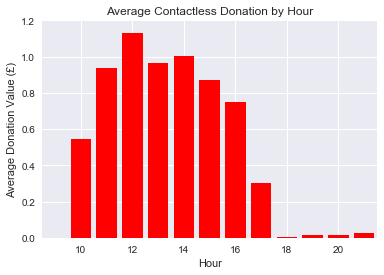

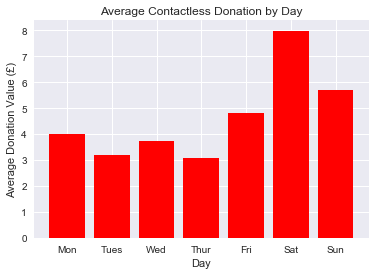

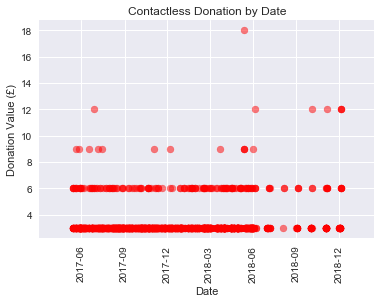

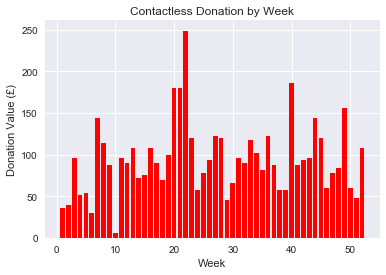

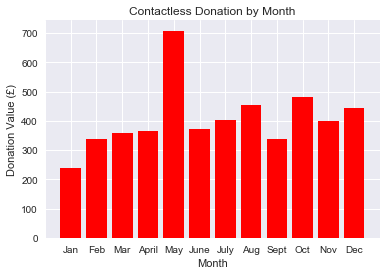

In [574]:
# process time/date data
Contactless_DF['Hour'] = Contactless_DF['Donation Date'].dt.hour
Contactless_DF['Day'] = Contactless_DF['Donation Date'].dt.dayofweek
Contactless_DF['Week'] = Contactless_DF['Donation Date'].dt.weekofyear
Contactless_DF['Month'] = Contactless_DF['Donation Date'].dt.month

# Get first and last Dates
startdate =Contactless_DF['Donation Date'].min()
enddate =Contactless_DF['Donation Date'].max()
perioddays= (enddate - startdate)
periodweeks= (enddate - startdate)/7
lastyear=pd.to_datetime(enddate - pd.DateOffset(years=1))      

Contactlessyear_DF=Contactless_DF[Contactless_DF['Donation Date']>"2017-05-13"]

###

print("Time Period:" + str(lastyear) + " to " + str(enddate))
print(Contactlessyear_DF.shape)

# Create Hourly Averages
ContactlessHour = Contactless_DF.groupby([Contactless_DF['Hour']], sort=True).agg({'Value': 'sum'})
ContactlessHour['Mean']=ContactlessHour['Value']/perioddays.days
# Plot Hourly Averages
plt.figure(1)
plt.bar(ContactlessHour.index,ContactlessHour['Mean'], color='red')
plt.title('Average Contactless Donation by Hour')
plt.axis((8.5,21.5,0,1.2))
plt.xlabel('Hour')
plt.ylabel('Average Donation Value (£)')
plt.show()

# Create Daily Averages
ContactlessDaily = Contactlessyear_DF.groupby([Contactlessyear_DF['Day']], sort=True).agg({'Value': 'sum'})
ContactlessDaily['Mean']=ContactlessDaily['Value']/periodweeks.days
# Plot Daily Averages
plt.figure(1)
plt.bar(ContactlessDaily.index,ContactlessDaily['Mean'],color='red')
plt.title('Average Contactless Donation by Day')
plt.xticks(np.arange(7), ('Mon','Tues','Wed','Thur','Fri','Sat','Sun'))
plt.xlabel('Day')
plt.ylabel('Average Donation Value (£)')
plt.show()

###

# Create Daily Total by Date
ContactlessDaily = Contactlessyear_DF.groupby([Contactlessyear_DF['Donation Date']], sort=True).agg({'Value': 'sum'})
#plot daily donations
plt.figure(4)
plt.scatter(ContactlessDaily.index,ContactlessDaily['Value'],alpha=0.5,c='red')
plt.title('Contactless Donation by Date')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.ylabel('Donation Value (£)')
plt.show()

# Create Weekly Totals
ContactlessWeekly = Contactlessyear_DF.groupby([Contactlessyear_DF['Week']], sort=True).agg({'Value': 'sum'})
#plot weekly donations
plt.figure(3)
plt.bar(ContactlessWeekly.index,ContactlessWeekly['Value'],color='red')
plt.title('Contactless Donation by Week')
plt.xlabel('Week')
plt.ylabel('Donation Value (£)')
#plt.yticks([]) 
plt.show()

# Create Monthly Totals
ContactlessMonthly = Contactlessyear_DF.groupby([Contactlessyear_DF['Month']], sort=True).agg({'Value': 'sum'})
#plot Monthly donations
plt.figure(2)
plt.bar(ContactlessMonthly.index,ContactlessMonthly['Value'],color='red')
plt.title('Contactless Donation by Month')
plt.xticks(np.arange(13), ('','Jan','Feb','Mar','April','May','June','July','Aug','Sept','Oct','Nov','Dec',''))
plt.xlabel('Month')
plt.ylabel('Donation Value (£)')
#plt.yticks([]) 
plt.show()

### Terminal Usage

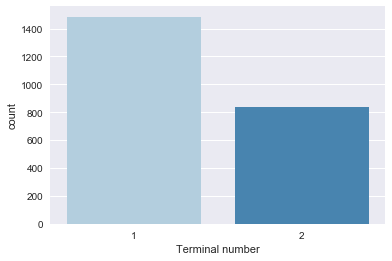

Terminal Usage:
1    1485
2     841
Name: Terminal number, dtype: int64
Terminal 1 = 5th floor, Terminal 2=Ground floor


In [575]:
# Plot Terminal usage
sns.countplot(x="Terminal number", data=Contactless_DF, palette='Blues')
plt.show()

# get Terminal usage
print("Terminal Usage:")
print(Contactless_DF['Terminal number'].value_counts())
print("Terminal 1 = 5th floor, Terminal 2=Ground floor")

### Contactless donations by terminal and time

We have looked at the distribution of contactless donations by both time and location independantly, we can also look at both time and location on the same plot. 

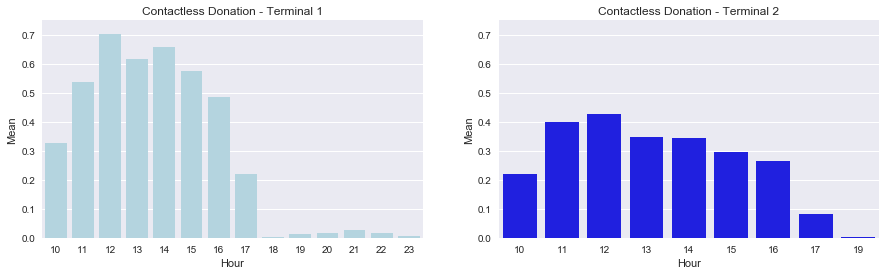

In [576]:
# split Terminal 1 and Terminal 2
Contactless1_DF=Contactless_DF[Contactless_DF['Terminal number']==1]
Contactless2_DF=Contactless_DF[Contactless_DF['Terminal number']==2]

# Create Hourly Averages by Terminal
ContactlessHour1 = Contactless1_DF.groupby([Contactless1_DF['Hour']], sort=True).agg({'Value': 'sum'})
ContactlessHour1['Mean']=ContactlessHour1['Value']/perioddays.days
ContactlessHour2 = Contactless2_DF.groupby([Contactless2_DF['Hour']], sort=True).agg({'Value': 'sum'})
ContactlessHour2['Mean']=ContactlessHour2['Value']/perioddays.days

# Create axis
sns.set(style="darkgrid")
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Contactless Donation - Terminal 1')
axis2.set_title('Contactless Donation - Terminal 2')
# control x and y limits
axis1.set_ylim([0, 0.75])
axis2.set_ylim([0, 0.75]) 
axis1.set_xlim([10, 23])
axis2.set_xlim([10, 23]) 
# Plot Hourly Averages by Terminal
facet = sns.barplot(ContactlessHour1.index,'Mean',data=ContactlessHour1,color='LightBlue',ax=axis1)
facet = sns.barplot(ContactlessHour2.index,'Mean',data=ContactlessHour2,color='Blue',ax=axis2)

## Card Usage


Card Type Usage:
Visa          1972
MasterCard     318
Maestro         36
Name: Type, dtype: int64


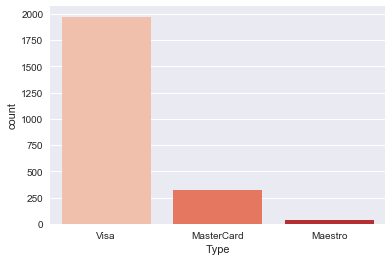

In [577]:
# get Type usage
print("\nCard Type Usage:")
print(Contactless_DF['Type'].value_counts())

sns.countplot(x="Type", data=Contactless_DF,palette='Reds')
plt.show()

## Importance of Donations from Visitors from Overseas?

The first 6 digits of a credit debit card are used to identify the card issuer, so its possible to cross reference  these digits with a list of UK card issuers to see how many of the cards are from the UK and how many are from overseas, this will give us an idea of the importance of donations from overseas visitors.

There are a number of api's that can be used to get details of card issuers I used binlist https://binlist.net/ when i was looking into this. Lists are also available I downloaded a list from https://www.creditcardvalidator.org/country/gb-united-kingdom which i then imported as a csv and loaded into a dictionary. 

A number of bin numbers were recognised, and looking each one up separately was going to take too long, so i serached for another reference site and found http://binchecker.com/ which allows you to look up blocks of 10 number.

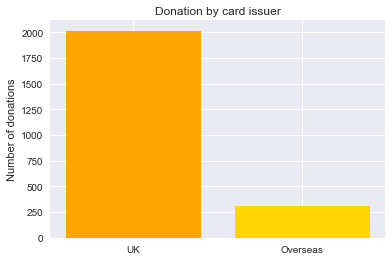

(2326,) donations
2014 cards from 159 UK card issuers
312 cards from 102 overseas card issuers


In [586]:
# Get card provider codes

for index,row in Contactless_DF.iterrows():
    x=row.loc['ref']
    ref=x.split(' - ')
    Contactless_DF.loc[index,'Provider']=(ref[0])

# Create Overseas dict
overseas=0
overseasprov={}
UK=0
UKprov={}

# Copy biindata into a dictionary
biindict = {}
for x in Biin_DF['BIIN']:
    biindict[x]='1'

# increment counts for uk / overseas    
for x in Contactless_DF['Provider']:
    if x in biindict.keys():
        UK=UK+1
        UKprov[x]=1
    else:
        overseas=overseas+1
        overseasprov[x]=1
        
#plot the overseas card issuers
plt.figure(1)
x=[1,2]
y=[int(UK),int(overseas)]
plt.bar(x,y,color=['orange','gold'])
plt.title('Donation by card issuer')
plt.xticks((1,2), ('UK','Overseas'))
plt.ylabel('Number of donations')
plt.show()

# print stats
print(str(Contactless_DF['Provider'].shape)+ " donations")      
print(str(UK) + " cards from " + str(len(UKprov)) + " UK card issuers")
print(str(overseas) + " cards from " + str(len(overseasprov)) +" overseas card issuers")

## How often do visitors donate?

While we don't have username or user identity data, we do have the card numbers used to make donations. These card numbers relate to card used for the donation and it should be noted that while each card number is unique some people may have more than 1 credit/debit card and there would be no way to link multiple cards to the same user, so this data is more 'best guess'  that it is "Data Science'. It is also worth noting that card numbers are sensative with respect to GDPR so any actual Card numbers should be replaced with a one way encrypted reference which will remain unique without exposing the card Data.

### Create a dictionary of contactless doner id's

In [581]:
# Copy card refs into a dictionary
carddict = {}

# Iterate over cards in ref column
cards = Contactless_DF["ref"]
for c in cards:
    # If the c is in carddict, add 1
    if c in carddict.keys():
        carddict[c]=((carddict)[c])+1
    # Else add the count to carddict, set the value to 1
    else:
        carddict[c]=1  
        
# Create a dictionary of multi use cards
MultiUseDict={}

for c in carddict:
    if carddict[c] > 1:
       MultiUseDict[c]=carddict[c]        

### Get the distribution of the contactless donation frequencies

In [557]:
# count multiuse values
multicountdict = {}

for value in carddict:
    if (carddict[value]) in multicountdict.keys():
        multicountdict[(carddict[value])]=multicountdict[(carddict[value])]+1
    else:    
        multicountdict[(carddict[value])]=1
print(multicountdict)

{1: 1981, 2: 133, 3: 18, 4: 5, 5: 1}


### Plot contactless frequency

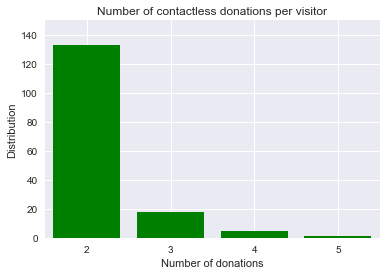

In [558]:
#get the data to plot
lists=sorted(multicountdict.items())
x,y =zip(*lists)
#plot the contact frequency data
axis=plt.bar(x,y,color='green')
plt.title('Number of contactless donations per visitor')
plt.axis((1.5,5.5,0,150))
plt.xticks(range(2,6))
plt.xlabel('Number of donations')
plt.ylabel('Distribution')
plt.show()

### Exploring Multiple Donations

In [559]:
# Look at multiple payments 
MultiplePayments=Contactless_DF[Contactless_DF['ref'].isin(MultiUseDict)]
print(MultiplePayments.shape)
print(MultiplePayments.head(5))
print("\n")
print(MultiplePayments.info())

(345, 11)
     Terminal number  Type            ref     status  Value  \
25                 1  Visa  492914 - 6002  Committed    3.0   
26                 1  Visa  492914 - 6002  Committed    3.0   
122                1  Visa  465946 - 8235  Committed    3.0   
123                1  Visa  465946 - 8235  Committed    3.0   
151                1  Visa  498824 - 8074  Committed    3.0   

          Donation Date  Hour  Day  Week  Month  Provider  
25  2016-11-13 16:58:00    16    6    45     11  492914.0  
26  2016-11-13 16:58:00    16    6    45     11  492914.0  
122 2016-12-29 15:58:00    15    3    52     12  465946.0  
123 2016-12-29 15:58:00    15    3    52     12  465946.0  
151 2017-07-01 15:03:00    15    5    26      7  498824.0  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 25 to 2339
Data columns (total 11 columns):
Terminal number    345 non-null int64
Type               345 non-null object
ref                345 non-null object
status             345 non

### Categorizing Multiple Payments

Looking at the data for cards used more than once, we can see that we have 363 payments on 165 cards. If we look at the Date and Time of the payments we can see that some of the payments from a single card are made of the same day while others are made on different dates, suggesting that there are might be different  reasons for making multiple donations. 

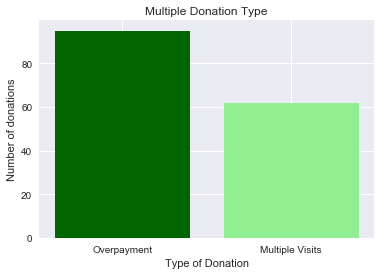

95 people overpaid.
62 people donated on multiple visits.


In [560]:
# create dictionary
overpayer={}; everytimer={}; everytimerid={}

for card in MultiUseDict:
    transdate=pd.DataFrame()
    transdate[card]=(MultiplePayments[MultiplePayments['ref']==card]['Donation Date'])
    unique=str(transdate.nunique())
    p=re.compile(r'\d+')
    uniqueno=p.findall(unique)
    if (uniqueno[2])=="1":
        (overpayer)[card]=1
    else:
        (everytimer)[card]=1
        (everytimerid)[card]=card
        
#plot the multi payment categories
x=[1,2]
y=[(len(overpayer)),(len(everytimer))]
plt.bar(x,y,color=['darkgreen','lightgreen'])
plt.title('Multiple Donation Type')
plt.xlabel('Type of Donation')
plt.xticks((1,2), ('Overpayment','Multiple Visits'))
plt.ylabel('Number of donations')
plt.show()

print(str(len(overpayer))+" people overpaid.")
print(str(len(everytimer))+" people donated on multiple visits.")

## Overpayers versus Everytimers

We can classify multiple donations into 2 groups, **'Overpayers'** and **'Everytimers'**.

The 'Overpayers' are the people that make more than one payment on the same card on the same day. They may be groups  that want to make a larger donation for the group or individuals that simply think the experience is worth more than the recommended £3. This data is useful when setting the level of the ask. BALTIC have recently invested in a new model of contactless devices which allows a selection of £2,£3,£5 or £10 which should give us more detail on how much people would donate given a choice.

The 'Everytimers' are those cards that have been used to make more than 1 donation on more than one date. These signify the true repeat donations. It is worth noting that the gallery have a high level of tourists and visitors from outside of the region that only visit once or visit seldomly, so the number of return donations is likely to be low. It is likely that repeat donations come from people within the region.

## Terminal Loyalty

We know that some people have made donations on more than 1 occasion, but which terminal did they use and have they use the same terminal each time?

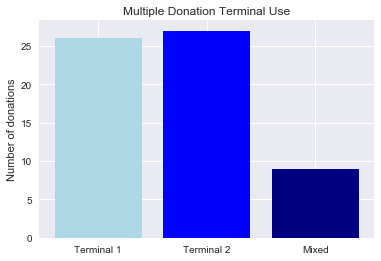

26 donations at terminal 1
27 donations at terminal 2
9 donations at multiple terminals


In [561]:
# create dictionary
terminal1={};terminal2={};multiterminal={}

for card in everytimerid:
    transterm=pd.DataFrame()
    transterm[card]=(MultiplePayments[MultiplePayments['ref']==card]['Terminal number'])
    unique=str(transterm.nunique())
    p=re.compile(r'\d+')
    uniqueterm=p.findall(unique)
    if uniqueterm[2]=="1":
        termid=p.findall(str(MultiplePayments[MultiplePayments['ref']==card]['Terminal number']))
        #print(termid[1])
        if termid[1] =="1":
            terminal1[card]=1
        else:
            terminal2[card]=1
    else:
        multiterminal[card]=1
#plot the multi payment categories
x=[1,2,3]
y=[(len(terminal1)),(len(terminal2)),(len(multiterminal))]
plt.bar(x,y,color=['lightblue','blue','navy'])
plt.title('Multiple Donation Terminal Use')
#plt.xlabel('Terminal')
plt.xticks((1,2,3), ('Terminal 1','Terminal 2','Mixed'))
plt.ylabel('Number of donations')
plt.show()
print(str(len(terminal1))+ " donations at terminal 1")
print(str(len(terminal2))+ " donations at terminal 2")
print(str(len(multiterminal))+ " donations at multiple terminals")

# What we have learnt so far!

Over one year we recorder :

### 1635 Observations

we Used just 3 data points from those observations: 

### Date , Terminal and Card Number

enabling us to :

### Establish usage profiles for each terminal

### Build hourly, weekly, monthly time profiles

### Identify Multiple Donations from the same Visitor

### Investigate the importance of donations from overseas visitors

From this we discovered:

## 63.8% of Contactless Donations are made on the 5th Floor Terminal 

###

## 85% of People that have made multiple contactless donations make them on the same terminal

![Crew](Images/Crew.png?raw=true)

# Bringing Data in from other Sources

Having looked at the donation by date, time and terminal location and and invistigated repeat donations we have a basic idea of donation behaviour. At this stage if we want to look in more detail at the factors affecting contactless donations or donations in general we will have to bring in other sources of data. 

One of the factors that we might influence the level of donations is the number of visitors to the gallery. This is Data that is already collected, so should be easiliy accessible.


# Final words

We hear about 'Big Data' all the time, but I hope that that this presentation showed that even if you only have a 'Tiny' about of data,  with a bit of lateral thinking that you can still gain useful insight that your business can use to make informed decisions.

The presentation is available at xxx and you can find me on  github at https://github.com/davidcoxon or linkedin at https://www.linkedin.com/in/davidcoxon/

![Thank you!](Images/Thankyou.jpg?raw=true)

The presentation is available at xxx and you can find me on  github at https://github.com/davidcoxon or linkedin at https://www.linkedin.com/in/davidcoxon/

If you have any feedback about the code, the concepts, or the statistics in this presentation please feel free to pass it on, Data Science is all about peer review and I would be more than happy to here what i'm doing wrong or how I might improve.

If you have not taken the opportunity to give a talk yet - please consider volunteering.

## Thank you for listening!